In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import pickle
import os
import time

import seaborn as sns
sns.set()
from matplotlib import style
# style.use('ggplot')

from fastai.tabular import *

In [2]:
df = pd.read_csv('sp500_wti.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
def cat_cont_split(df, maxcard=55, omit_vars=['Date', 'Adj Close', 'Return', 'target_return']):
    """Helper function that returns column names of categorical & continuous features from df."""
    cat_feats, cont_feats = [], []
    for col in df:
        if col in omit_vars: 
            continue
        if (df[col].dtype==int or df[col].dtype==float) and df[col].unique().shape[0] > maxcard:
            cont_feats.append(col)
        else:
            cat_feats.append(col)
    return cat_feats, cont_feats
    
cat_vars, cont_vars = cat_cont_split(df)
print(len(cat_vars), 'Categorical Features:')
print(cat_vars)
print(len(cont_vars), 'Continuous Features:')
print(cont_vars)

19 Categorical Features:
['volatility_bbhi', 'volatility_bbli', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'ticker', 'exchange', 'sector', 'industry', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
11 Continuous Features:
['volume_obv', 'volume_fi', 'volatility_bbm', 'volatility_bbw', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'momentum_ao', 'momentum_roc', 'Dayofyear', 'Elapsed']


In [4]:
class Categorifier:
    ''' Transform categorical features into category types '''
    def apply_train(self, df, cat_vars):
        self.cat_vars = cat_vars
        self.categories = {}
        for v in self.cat_vars:
            df.loc[:, v] = df.loc[:, v].astype('category').cat.as_ordered()
            self.categories[v] = df[v].cat.categories
            
    def apply_test(self, df_test):
        for v in self.cat_vars:
            df_test.loc[:, v] = pd.Categorical(df[v], categories=self.categories[v], ordered=True)

cat = Categorifier()
cat.apply_train(df, cat_vars)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197718 entries, 0 to 1197717
Data columns (total 34 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Date                       1197718 non-null  datetime64[ns]
 1   Adj Close                  1197718 non-null  float64       
 2   volume_obv                 1197718 non-null  float64       
 3   volume_fi                  1197718 non-null  float64       
 4   volatility_bbm             1197718 non-null  float64       
 5   volatility_bbw             1197718 non-null  float64       
 6   volatility_bbhi            1197718 non-null  category      
 7   volatility_bbli            1197718 non-null  category      
 8   trend_macd                 1197718 non-null  float64       
 9   trend_macd_signal          1197718 non-null  float64       
 10  trend_macd_diff            1197718 non-null  float64       
 11  trend_psar_up_indicator    1197718 no

In [5]:
last_day = df['Date'].max()
cut_day = last_day + dt.timedelta(-30)
train_df = df[df['Date'] <= cut_day].sort_values(by='Date', ascending=False).reset_index(drop=True)
test_df = df[(df['Date'] > cut_day) & (df['Date'] < last_day)].sort_values(by='Date', ascending=False).reset_index(drop=True)
train_df.shape, test_df.shape, train_df.Date.min(), train_df.Date.max(), test_df.Date.min(), test_df.Date.max()

((1188058, 34),
 (9177, 34),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2020-01-17 00:00:00'),
 Timestamp('2020-01-21 00:00:00'),
 Timestamp('2020-02-14 00:00:00'))

In [6]:
# cut = df['Date'][(df['Date']==df['Date'][len(test_df)])]
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

In [7]:
data = (
        TabularList.from_df(train_df, cat_names=cat_vars, cont_names=cont_vars+['Return'])
        .split_by_idx(valid_idx)
        .label_from_df(cols='target_return', label_cls=FloatList)
        .add_test(TabularList.from_df(test_df, cat_names=cat_vars, cont_names=cont_vars+['Return']))
        .databunch()
        )

In [8]:
learn = tabular_learner(data, layers=[1024, 512], 
                        ps=[0.001, 0.01], emb_drop=0.1, metrics=rmse)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(486, 51)
    (5): Embedding(3, 3)
    (6): Embedding(13, 7)
    (7): Embedding(105, 22)
    (8): Embedding(12, 6)
    (9): Embedding(13, 7)
    (10): Embedding(54, 15)
    (11): Embedding(32, 11)
    (12): Embedding(6, 4)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=167, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


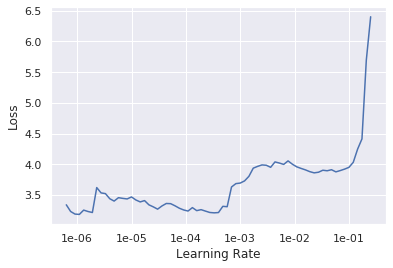

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(2, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,2.464340,1.958164,1.313912,02:37
1,2.283106,2.093826,1.364012,02:39


In [12]:
learn.fit_one_cycle(2, 3e-4, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,2.055225,2.082272,1.357113,02:35
1,1.981580,2.133453,1.377358,02:39


In [15]:
learn.fit_one_cycle(2, 1e-4, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,2.064931,2.027239,1.339726,02:39
1,1.693163,2.084116,1.366851,02:37


In [17]:
learn.fit_one_cycle(2, 1e-5, wd=0.2)
learn.save('stage0_no_norm')

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,1.700115,2.063178,1.360599,02:34
1,1.656169,2.095934,1.371656,02:36


In [9]:
# learn.load('stage0_no_norm')
learn.load('stage0')

Learner(data=TabularDataBunch;

Train: LabelList (1178399 items)
x: TabularList
volatility_bbhi 0.0; volatility_bbli 0.0; trend_psar_up_indicator 0.0; trend_psar_down_indicator 0.0; ticker GRMN; exchange NASDAQ; sector CAPITAL GOODS; industry INDUSTRIAL MACHINERY/COMPONENTS; Year 2019; Month 12; Week 51; Day 19; Dayofweek 3; Is_month_end False; Is_month_start False; Is_quarter_end False; Is_quarter_start False; Is_year_end False; Is_year_start False; volume_obv 87.3275; volume_fi 0.0010; volatility_bbm 3.0238; volatility_bbw 0.0856; trend_macd 0.0301; trend_macd_signal 0.0368; trend_macd_diff -0.0067; momentum_ao 0.0310; momentum_roc 1.1918; Dayofyear 353.0000; Elapsed 1576713600.0000; Return 0.1744; ,volatility_bbhi 0.0; volatility_bbli 0.0; trend_psar_up_indicator 1.0; trend_psar_down_indicator 0.0; ticker DISH; exchange NASDAQ; sector CONSUMER SERVICES; industry TELEVISION SERVICES; Year 2019; Month 12; Week 51; Day 18; Dayofweek 2; Is_month_end False; Is_month_start False; Is_quart

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

(13, 2)


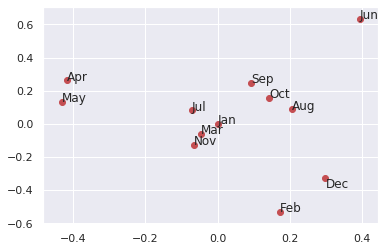

In [11]:
# Month
moy_id = 9
moy_weights = to_np(next(learn.layer_groups[0][moy_id].parameters()))
# moy_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(moy_weights)
# moy_2d.shape
moy_2d = TSNE(n_components=2, metric='cosine').fit_transform(moy_weights)
moy_2d = PCA(n_components=2).fit(moy_weights.T).components_.T
print(moy_2d.shape)

plt.figure()
moy_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']#, 'NA']
plt.scatter(moy_2d[:-1, 0], moy_2d[:-1, 1], c='r')#, c=range(len(moy_names)))
for p, s in zip(moy_2d, moy_names):
    if s == 'Dec':
        plt.annotate(s=s, xy=(p[0], p[1]-.06))
    else:
        plt.annotate(s=s, xy=(p[0], p[1]))
plt.savefig('month.png')

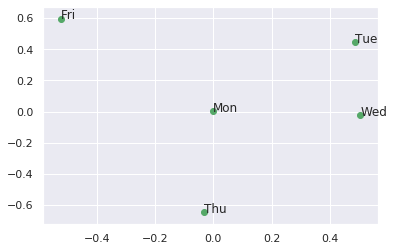

In [12]:
# Dayofweek
dow_id = 12
dow_weights = to_np(next(learn.layer_groups[0][dow_id].parameters()))
# dow_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(dow_weights)
# dow_2d = TSNE(n_components=2, metric='cosine').fit_transform(dow_temp)
dow_2d = PCA(n_components=2).fit(dow_weights.T).components_.T
plt.figure()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
# plt.plot(emb2d[:, 0], emb2d[:, 1], 'ro', )
plt.scatter(dow_2d[:-1, 0], dow_2d[:-1, 1], c='g')#, c=range(len(dow_names)))
for p, s in zip(dow_2d, dow_names):
    plt.annotate(s=s, xy=(p[0], p[1]))

12 ['BASIC INDUSTRIES', 'CAPITAL GOODS', 'CONSUMER DURABLES', 'CONSUMER NON-DURABLES', 'CONSUMER SERVICES', 'ENERGY', 'FINANCE', 'HEALTH CARE', 'MISCELLANEOUS', 'PUBLIC UTILITIES', 'TECHNOLOGY', 'TRANSPORTATION'] (13, 7)


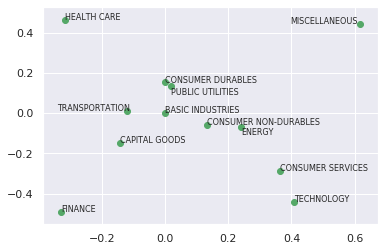

In [13]:
## Sector
emb_id, emb_str = 6, 'sector'
emb_names = train_df[emb_str].cat.categories
emb_weights = to_np(next(learn.layer_groups[0][emb_id].parameters()))
print(len(emb_names), list(emb_names), emb_weights.shape)
# dow_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(dow_weights)
# emb_2d = TSNE(n_components=2, metric='cosine').fit_transform(emb_weights)
emb_2d = PCA(n_components=2).fit(emb_weights.T).components_.T
# emb_2d = umap.UMAP(n_neighbors=5,
#                       min_dist=0.3,
#                       metric='correlation').fit_transform(emb_weights)

plt.figure()
# plt.plot(emb2d[:, 0], emb2d[:, 1], 'ro', )
plt.scatter(emb_2d[:-1, 0], emb_2d[:-1, 1], c='g')#, c=range(len(emb_names)) )
for p, s in zip(emb_2d, emb_names):
#     plt.annotate(s=s, xy=(p[0], p[1]), fontsize=8)
    if s == 'PUBLIC UTILITIES':
        plt.annotate(s=s, xy=(p[0], p[1]-.04), fontsize=8)      
#     elif s == 'CONSUMER DURABLES':
#         plt.annotate(s=s, xy=(p[0], p[1]+.02), fontsize=8)  
    elif s == 'TRANSPORTATION':
        plt.annotate(s=s, xy=(p[0]-.22, p[1]), fontsize=8)
    elif s == 'ENERGY':
        plt.annotate(s=s, xy=(p[0], p[1]-.04), fontsize=8)   
    elif s == 'MISCELLANEOUS':
        plt.annotate(s=s, xy=(p[0]-.22, p[1]), fontsize=8)   
    else:
        plt.annotate(s=s, xy=(p[0], p[1]), fontsize=8)
plt.savefig('sector.png')

In [14]:
info_df = pd.read_csv('./data/historical_stocks.csv')
info_df = info_df.drop(columns=['name'])
tickers = list(df['ticker'].unique())
info_df = info_df[info_df['ticker'].isin(tickers)].sort_values(by='ticker').reset_index(drop=True)
info_df

,ticker,exchange,sector,industry
0,A,NYSE,CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,AAL,NASDAQ,TRANSPORTATION,AIR FREIGHT/DELIVERY SERVICES
2,AAP,NYSE,CONSUMER SERVICES,OTHER SPECIALTY STORES
3,AAPL,NASDAQ,TECHNOLOGY,COMPUTER MANUFACTURING
4,ABBV,NYSE,HEALTH CARE,MAJOR PHARMACEUTICALS
5,ABC,NYSE,HEALTH CARE,OTHER PHARMACEUTICALS
6,ABMD,NASDAQ,HEALTH CARE,MEDICAL/DENTAL INSTRUMENTS
7,ABT,NYSE,HEALTH CARE,MAJOR PHARMACEUTICALS
8,ACN,NYSE,MISCELLANEOUS,BUSINESS SERVICES
9,ADBE,NASDAQ,TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


485


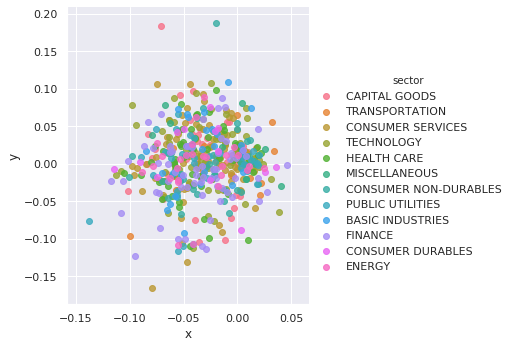

In [15]:
## Ticker
emb_id, emb_str = 4, 'ticker'
emb_names = train_df[emb_str].cat.categories
print(len(emb_names) )#, list(emb_names))
emb_weights = to_np(next(learn.layer_groups[0][emb_id].parameters()))
# np.savetxt('tick_emb.tsv', emb_weights, delimiter='\t')

# emb_2d = TSNE(perplexity=60, n_components=2, init='pca', n_iter=int(1e4), random_state=12).fit_transform(emb_weights)
# emb_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(emb_weights)
# emb_2d = TSNE(n_components=2, metric='cosine').fit_transform(emb_weights)
emb_2d = PCA(n_components=2).fit(emb_weights.T).components_.T

# plt.scatter(emb_2d[:-1, 0], emb_2d[:-1, 1], c=LabelEncoder().fit_transform(info_df.loc[:, 'sector']) )
emb_df = info_df.copy()
emb_df['x'] = emb_2d[:-1, 0]
emb_df['y'] = emb_2d[:-1, 1]

sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue='sector' )#, legend=False)
# plt.legend(loc='best')
plt.show()

## UMAP

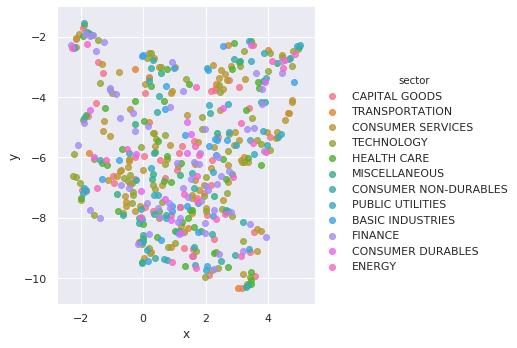

In [17]:
import umap
# emb_2d = umap.UMAP(n_neighbors=5, min_dist=0.2, metric='correlation').fit_transform(emb_weights[:-1, :])
emb_umap = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='cosine').fit_transform(emb_weights[:-1, :])
emb_df = info_df.copy()
emb_df['x'] = emb_2d[:, 0]
emb_df['y'] = emb_2d[:, 1]
sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue='sector' )#, legend=False)
# for p, s in zip(emb_umap, emb_names):
#     plt.annotate(s=s, xy=(p[0], p[1]))
plt.show()

## Similarity

In [18]:
norms = np.linalg.norm(emb_weights[:-1, :], axis=1, keepdims=True)
# norms = np.sqrt(np.square(emb_weights).sum(axis=1, keepdims=True))
normed_embs = emb_weights[:-1, :] / norms
# normed_embs.shape
sims = np.matmul(normed_embs, normed_embs.T)
print(sims.shape, info_df.shape)

(485, 485) (485, 4)


NVDA:
    - 'MNST',  monster, fast growing
    - 'FB', IT 
    - 'DFS', Discover Bank, fast growing
    - 'AKAM', Akamai, IT
    - 'CTSH', Cognizant Tech Solutions, IT
    - 'CHTR', Charter, communication services
    - 'ADP', IT
    - 'AMZN', IT
    - 'EXPE', Expedia, IT
    - 'XRAY', health care supplies, fast growing

245     IVZ
174      FE
251    JNPR
138     DRE
170      FB
154     EOG
248     JEC
447       V
351     PFE
122     CXO
303    MNST
444     URI
153     EMR
191    GILD
78       CB
203     HAL
314     MTD
268      LB
115     CSX
378     REG
41     ANTM
348    PCAR
468     WMB
265     KSS
213     HLT
61      BBY
356     PHM
59      BAC
8       ACN
12      ADP
Name: ticker, dtype: object


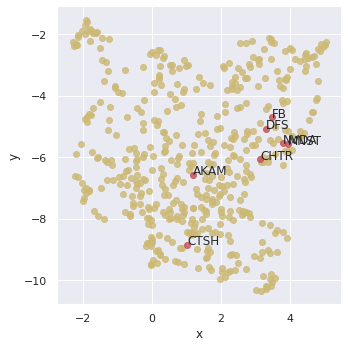

In [19]:
k = 30
# ticker = 'CFG'
ticker = 'NVDA'
tid = np.where(info_df['ticker'] == ticker)[0].item()
nearest = (-sims[tid, :]).argsort()[1:k+1]
print(info_df.iloc[nearest, :]['ticker'])

v = "Hue"
nearest = ['MNST', 'FB', 'DFS', 'AKAM', 'CTSH', 'CHTR']#, 'ADP', 'AMZN', 'EXPE', 'XRAY']
emb_df[v] = 'g'
emb_df.loc[emb_df['ticker'].isin(nearest+[ticker]), v] = 'k'
# emb_df.at[tid, v] = 'r'
# emb_df[v] = emb_df['ticker'].isin(nearest).astype(str)
# emb_df.at[tid, v] = '##'
# # emb_df.loc[:, v] = emb_df.loc[:, v].astype('category').cat.as_ordered()
# # emb_df.loc[:, 'mark'] = emb_df.loc[:, 'mark'].astype('str')
# np.where(emb_df['Hue'] != 'g')

sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue=v, legend=False, palette=['y', 'r'])
# plt.scatter(emb_umap[:, 0], emb_umap[:-1, 1], c='g') )
for p, s in zip(emb_2d, emb_names):
    if s in nearest + [ticker]:
        plt.annotate(s=s, xy=(p[0], p[1]))
plt.show()

WFC (Wells Fargo):
    - 'ETFC': E Trader, financial
    - 'STT': State Street Corp., bank
    - 'CMA': Comerica, Bank
    - 'AXP': Amex, financial
    - 'PGR': Progressive Insurance, Financial
    - 'SPGI', S&P Global, Inc., Financial & Data
    
    
'CFG', Citizens Financial
    - 'HIG', Hartfor Financial
    - 'BLK', BlackRock, financial
    - 'DFS', Discover bank
    - 'JPM', JP Morgan Chase
    - 'AFL', Aflac, Insurance, financial
    - 'BAC', Bank of America

306     MPC
211     HIG
40     ANSS
323    NFLX
324      NI
101     CMI
67      BLK
126     DFS
424     TPR
432     TXN
57      AZO
188     FTV
252     JPM
25      ALB
18      AFL
297     MHK
84      CDW
436     UAL
153     EMR
460     WBA
331     NSC
69      BMY
317     MYL
370     PVH
59      BAC
208      HD
50      ATO
240      IR
15      AEE
183     FOX
Name: ticker, dtype: object


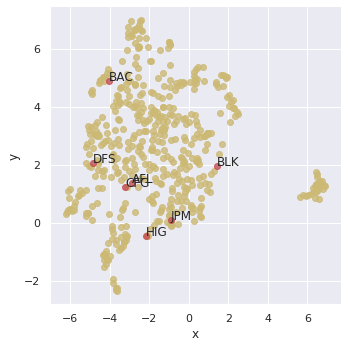

In [130]:
k = 30
ticker = 'CFG'
# ticker = 'RF'
tid = np.where(info_df['ticker'] == ticker)[0].item()
nearest = (-sims[tid, :]).argsort()[1:k+1]
nearest = info_df.iloc[nearest, :]['ticker']
print(nearest)

v = 'mark'
nearest = ['HIG', 'BLK', 'DFS', 'JPM', 'AFL', 'BAC']
emb_df[v] = emb_df['ticker'].isin(nearest+[ticker])  #.astype(int)
# emb_df.loc[tid, v] = '2'
# emb_df.loc[:, v] = emb_df.loc[:, v].astype('category').cat.as_ordered()
# emb_df
sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue=v, legend=False,  palette=['y', 'r', 'b'])

# # plt.scatter(emb_umap[:, 0], emb_umap[:-1, 1], c='g') )
for p, s in zip(emb_2d, emb_names):
    if s in nearest + [ticker]:
        plt.annotate(s=s, xy=(p[0], p[1]))
plt.show()

341     OKE
457      VZ
406     STT
369     PSX
158     ESS
53     AVGO
157      ES
438     UHS
286     MAC
159    ETFC
186     FTI
49     ARNC
453    VRSK
379    REGN
404    SPGI
261     KMI
463    WELL
91     CHRW
51     ATVI
56      AXP
22      AIZ
167       F
139     DRI
366    PRGO
364     PPG
17      AES
136    DLTR
428    TSCO
164    EXPD
354     PGR
Name: ticker, dtype: object


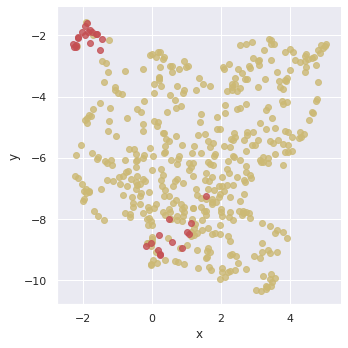

In [29]:
k = 30
ticker = 'WFC' #(Wells Fargo):

tid = np.where(info_df['ticker'] == ticker)[0].item()
nearest = (-sims[tid, :]).argsort()[1:k+1]
nearest = info_df.iloc[nearest, :]['ticker']
print(nearest)

v = 'mark' 
# nearest = ['ETFC', 'STT', 'CMA', 'AXP', 'PGR','SPGI']
emb_df[v] = emb_df['ticker'].isin(nearest.tolist()+[ticker])  #.astype(int)
sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue=v, legend=False,  palette=['y', 'r', 'b'])

# # plt.scatter(emb_umap[:, 0], emb_umap[:-1, 1], c='g') )
for p, s in zip(emb_2d, emb_names):
    if s in nearest + [ticker]:
        plt.annotate(s=s, xy=(p[0], p[1]))
plt.show()

In [27]:
nearest.tolist()

['OKE',
 'VZ',
 'STT',
 'PSX',
 'ESS',
 'AVGO',
 'ES',
 'UHS',
 'MAC',
 'ETFC',
 'FTI',
 'ARNC',
 'VRSK',
 'REGN',
 'SPGI',
 'KMI',
 'WELL',
 'CHRW',
 'ATVI',
 'AXP',
 'AIZ',
 'F',
 'DRI',
 'PRGO',
 'PPG',
 'AES',
 'DLTR',
 'TSCO',
 'EXPD',
 'PGR']

In [28]:
nearest+[ticker]

341     OKEWFC
457      VZWFC
406     STTWFC
369     PSXWFC
158     ESSWFC
53     AVGOWFC
157      ESWFC
438     UHSWFC
286     MACWFC
159    ETFCWFC
186     FTIWFC
49     ARNCWFC
453    VRSKWFC
379    REGNWFC
404    SPGIWFC
261     KMIWFC
463    WELLWFC
91     CHRWWFC
51     ATVIWFC
56      AXPWFC
22      AIZWFC
167       FWFC
139     DRIWFC
366    PRGOWFC
364     PPGWFC
17      AESWFC
136    DLTRWFC
428    TSCOWFC
164    EXPDWFC
354     PGRWFC
Name: ticker, dtype: object